# Diffusion

## 加载数据集

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_circles

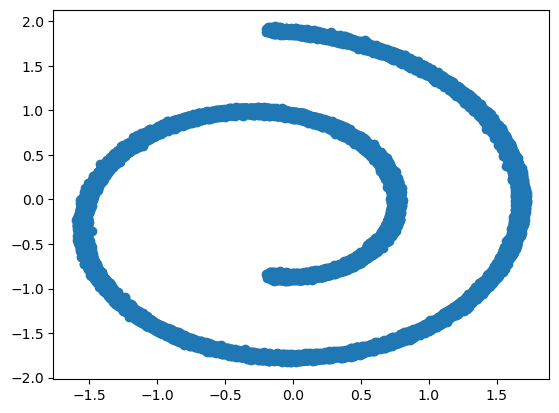

In [2]:
x, _ = make_swiss_roll(n_samples=100_000, noise=0.1)
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std()

plt.scatter(x[:, 0], x[:, 1])

## 转换为 Torch Tensor

In [3]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

In [4]:
X = torch.tensor(x, dtype=torch.float32)
X.shape

torch.Size([100000, 2])

In [5]:
dataset = TensorDataset(X)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [6]:
for batch_idx, data in enumerate(train_loader):
    print(data[0].shape)
    break

torch.Size([128, 2])


## 构建模型

- 这里需要加入 `timestep`

In [7]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [8]:
class Generate1D(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, time_emb_dim=32):
        super().__init__()
        
        # 时间步嵌入层
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, hidden_dim)
        )
        
        # 编码器（加入时间信息）
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
        )
        
        # 解码器（加入时间信息）
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
        )
     
    def encode(self, x, t):
        # 获取时间嵌入
        t_emb = self.time_mlp(t)
        # 将输入和时间嵌入连接
        x = torch.cat([x, t_emb], dim=1)
        h = self.encoder(x)
        return h
    
    def decode(self, z, t):
        # 获取时间嵌入
        t_emb = self.time_mlp(t)
        # 将潜在表示和时间嵌入连接
        z = torch.cat([z, t_emb], dim=1)
        return self.decoder(z)
    
    def forward(self, x, timestep):
        # 将整数时间步转换为张量
        if not isinstance(timestep, torch.Tensor):
            timestep = torch.tensor([timestep], dtype=torch.long, device=x.device)
        # 确保t的形状正确 (bs 相同)
        if timestep.dim() == 0:
            timestep = timestep.unsqueeze(0)
        # 扩展t以匹配batch大小
        timestep = timestep.expand(x.shape[0])
        
        h = self.encode(x, timestep)
        return self.decode(h, timestep)

In [9]:
model = Generate1D()

In [10]:
sample_data = X[0:10]
print("Input shape:", sample_data.shape)

print("Output shape:", model(sample_data, timestep=0).shape)

Input shape: torch.Size([10, 2])
Output shape: torch.Size([10, 2])


## 前向过程

In [11]:
T = 1_000

# 前向 diffusion 计算参数, alpha, beta
betas = torch.linspace(0.0001, 0.02, T) # (T,), Beta 越来越大
alphas = 1-betas # (T,) Alpha 越来越小

# alpha_t 累乘 (T,), [a1,a2,a3,....] -> [a1, a1*a2, a1*a2*a3, .....]
alphas_cumprod = torch.cumprod(alphas, dim=-1) # 逐渐变小, 表示噪声越来越多

print(f"Beta, {betas[::100]}")
print(f"Alpha, {alphas[::100]}")
print(f"Alpha CumProd, {alphas_cumprod[::100]}")

Beta, tensor([1.0000e-04, 2.0920e-03, 4.0840e-03, 6.0760e-03, 8.0680e-03, 1.0060e-02,
        1.2052e-02, 1.4044e-02, 1.6036e-02, 1.8028e-02])
Alpha, tensor([0.9999, 0.9979, 0.9959, 0.9939, 0.9919, 0.9899, 0.9879, 0.9860, 0.9840,
        0.9820])
Alpha CumProd, tensor([9.9990e-01, 8.9514e-01, 6.5635e-01, 3.9401e-01, 1.9357e-01, 7.7797e-02,
        2.5567e-02, 6.8683e-03, 1.5075e-03, 2.7024e-04])


In [22]:
def forward_diffusion(batch_x, batch_t, device):
    """执行前向加噪, 获得 t 步加噪后的数据
    - batch_x: (batch, xx), 
    - batch_t: (batch_size,)
    返回加噪后的数据和添加的噪声
    """
    batch_x, batch_t = batch_x.to(device), batch_t.to(device)
    # 为每个数据生成第 t 步的高斯噪音
    batch_noise_t = torch.randn_like(batch_x)
    # 获得指定时间步的 alpha
    batch_alphas_cumprod = alphas_cumprod.to(device)[batch_t].view(batch_x.size(0),1)
    
    # 前向过程的计算式子
    batch_x_t = torch.sqrt(batch_alphas_cumprod) * batch_x \
        + torch.sqrt(1-batch_alphas_cumprod) * batch_noise_t # 基于公式直接生成第 t 步加噪后数据
    
    return batch_x_t, batch_noise_t

In [24]:
batch_x = X[0:3]
batch_t = torch.tensor([5, 100, 200], dtype=torch.long)
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_x_t, batch_noise_t = forward_diffusion(batch_x, batch_t, device)
print(batch_x_t.shape, batch_noise_t.shape)

torch.Size([3, 2]) torch.Size([3, 2])


## 逆向过程

In [25]:
def backward_denoise(model, batch_x_t, device):
    """反向去噪的过程, 逆向 1000 次
    """
    # 初始化参数
    betas = torch.linspace(0.0001, 0.02, T) # (T,), Beta 越来越大
    alphas = 1-betas # (T,) Alpha 越来越小
    # alpha_t 累乘 (T,), [a1,a2,a3,....] -> [a1, a1*a2, a1*a2*a3, .....]
    alphas_cumprod = torch.cumprod(alphas, dim=-1) # 逐渐变小, 表示噪声越来越多
    # alpha_t-1 累乘 (T,), [1, a1, a1*a2, a1*a2*a3,.....]
    alphas_cumprod_prev = torch.cat(
        (torch.tensor([1.0]), alphas_cumprod[:-1]), 
        dim=-1
    ) # 会在 reserve 的时候用到
    variance = (1-alphas)*(1-alphas_cumprod_prev)/(1-alphas_cumprod) # denoise用的方差 (T,)

    steps = [batch_x_t, ] # 噪声的数据, 存储去噪的过程

    model = model.to(device)
    batch_x_t = batch_x_t.to(device)
    alphas = alphas.to(device)
    alphas_cumprod = alphas_cumprod.to(device)
    variance = variance.to(device)
    
    # BN 层的存在，需要 eval 模式避免推理时跟随 batch 的数据分布，
    # 但是相反训练的时候需要更加充分让它见到各种 batch 数据分布
    model.eval()

    with torch.no_grad():
        for t in range(T-1, -1, -1):
            batch_t = torch.full((batch_x_t.size(0),), t).to(device) # 当前的时间
            # 预测 x_t 时刻的噪音
            batch_predict_noise_t = model(batch_x_t, batch_t) # !!! 传入当前图片和当前的时刻

            # 生成 t-1 时刻的数据
            shape = (batch_x_t.size(0), 1)
            batch_mean_t = 1/torch.sqrt(alphas[batch_t].view(*shape)) * \
                (
                    batch_x_t -
                    (1-alphas[batch_t].view(*shape)) / \
                        torch.sqrt(1-alphas_cumprod[batch_t].view(*shape)) * \
                            batch_predict_noise_t
                ) # 当前的图减去噪声
            
            if t != 0:
                batch_x_t = batch_mean_t + \
                    torch.randn_like(batch_x_t) * \
                    torch.sqrt(variance[batch_t].view(*shape))
            else:
                batch_x_t = batch_mean_t

            steps.append(batch_x_t) # 保存每一次的数据
    return steps

In [32]:
model = Generate1D()
batch_x_t = torch.randn(size=(1, 2))  # (1,2) -> 模拟一个一维数据
steps = backward_denoise(model, batch_x_t, device)

In [33]:
len(steps), steps[100].shape

(1001, torch.Size([1, 2]))

## 模型训练

In [51]:
T = 1000
model = Generate1D().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001) # 优化器
loss_fn=nn.L1Loss() # 损失函数 (绝对值误差均值), 每个像素绝对值的偏差

In [54]:
model.train()
n_iter = 0
EPOCH = 30
for epoch in range(EPOCH):
    last_loss = 0
    for batch_x in train_loader:
        batch_x = batch_x[0].to(device)
        # 为每张图片生成随机 t 时刻
        batch_t = torch.randint(0, T, (batch_x.size(0),)).to(device)
        # 生成 t 时刻的加噪图片和对应噪音
        batch_x_t, batch_noise_t = forward_diffusion(batch_x, batch_t, device)
        # 模型预测 t 时刻的噪音
        batch_predict_t = model(batch_x_t, batch_t)
        loss = loss_fn(batch_predict_t, batch_noise_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        last_loss = loss.item()
        n_iter += 1

    print(f'epoch:{epoch}, loss={last_loss}')

epoch:0, loss=0.28785598278045654
epoch:1, loss=0.3955869972705841
epoch:2, loss=0.5228109955787659
epoch:3, loss=0.42537403106689453
epoch:4, loss=0.3659522235393524
epoch:5, loss=0.31666100025177
epoch:6, loss=0.3869072198867798
epoch:7, loss=0.34389644861221313
epoch:8, loss=0.28123384714126587
epoch:9, loss=0.24177691340446472
epoch:10, loss=0.28054720163345337
epoch:11, loss=0.3536757826805115
epoch:12, loss=0.37897810339927673
epoch:13, loss=0.3583446741104126
epoch:14, loss=0.29350972175598145
epoch:15, loss=0.33252620697021484
epoch:16, loss=0.40506553649902344
epoch:17, loss=0.3722057342529297
epoch:18, loss=0.359286904335022
epoch:19, loss=0.34762147068977356
epoch:20, loss=0.39109358191490173
epoch:21, loss=0.41185230016708374
epoch:22, loss=0.30826884508132935
epoch:23, loss=0.28712978959083557
epoch:24, loss=0.2944738268852234
epoch:25, loss=0.33066606521606445
epoch:26, loss=0.45095202326774597
epoch:27, loss=0.40584415197372437
epoch:28, loss=0.3258711099624634
epoch:29,

## 模型测试

In [60]:
batch_x_t = torch.randn(size=(100000, 2))  # (1,2) -> 模拟一个一维数据
steps = backward_denoise(model, batch_x_t, device)

Text(0, 0.5, 'Feature 2')

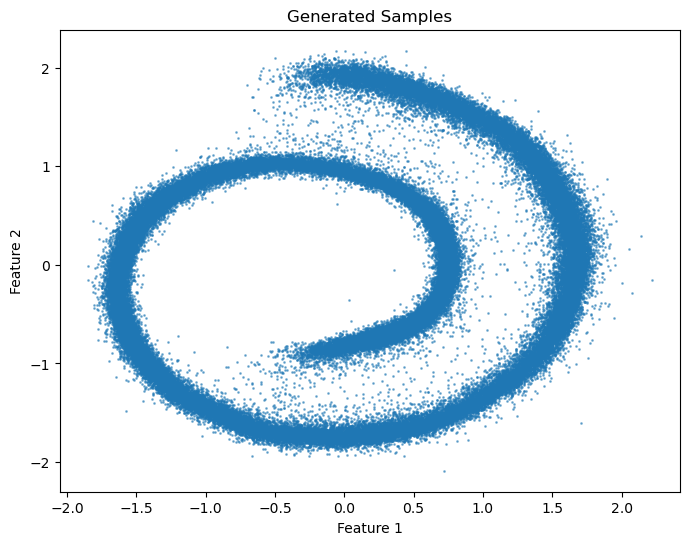

In [61]:
generated = steps[-1].cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(generated[:, 0], generated[:, 1], s=1, alpha=0.5)
plt.title(f'Generated Samples')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')